### This notebook deals wit the OFT behavior. The data was produced by Isla. 
GT 4/29/2022

In [1]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk')
import pandas as pd

import datetime
%matplotlib inline

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/'

Mounted at /content/drive


In [31]:
def load_spreadsheet(spreadsheet):
    """ 
    Loads the content of a spreadsheet in a pandas dataframe.
    Requires authentication. 

    Parameters:
    ==========
    spreadsheet: str
        name of the spreadsheet to be loaded
    Returns:
    ========
    df: pandas DataFrame
    """    
    worksheet = gc.open(spreadsheet).sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame.from_records(data)
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace =True)
    return df

Loading data

In [35]:
# Isla's file
data = ['PTSD2_OFT', 'PTSD4_OFT', 'PTSD6_OFT']
df = pd.concat((load_spreadsheet(x) for x in data), axis=0)
# converting columns and adding cohort_id
df[['center_occupancy', 'velocity_cmps',
    'floor_occupancy', 'distance_cm']] = df[['center_occupancy', 'velocity_cmps',
                                             'floor_occupancy', 'distance_cm']].apply(pd.to_numeric, errors='coerce')
df['cohort_id'] = df['cohort'].str.lower() + '_' + df['mouse_id']
df.set_index('cohort_id', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, ptsd2_81 to ptsd6_75
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        102 non-null    object 
 1   cohort            102 non-null    object 
 2   behavior          102 non-null    object 
 3   timepoint         102 non-null    object 
 4   mouse_id          102 non-null    object 
 5   center_occupancy  102 non-null    float64
 6   floor_occupancy   102 non-null    float64
 7   velocity_cmps     102 non-null    float64
 8   distance_cm       102 non-null    float64
dtypes: float64(4), object(5)
memory usage: 8.0+ KB


Loading all mice to take out sex and condition info

In [36]:
worksheet = gc.open('all_cohorts_data_4_27_22').sheet1
data = worksheet.get_all_values()
all_df = pd.DataFrame.from_records(data)
all_df.columns = all_df.iloc[0]
all_df.drop(all_df.index[0], inplace =True)

taking out necessary columns as index

In [37]:
new_df = all_df.set_index(['cohort_id', 'sex', 'condition'])
df2 = pd.DataFrame(index = new_df.index.unique())
df2.reset_index(inplace=True)
df2.set_index('cohort_id', inplace=True)
df2.index
# df2

Index(['ptsd1_5HT2Afl05a-5', 'ptsd1_5HT2Afl05a-7', 'ptsd1_5HT2ACre01a-3',
       'ptsd1_sert26a-3', 'ptsd1_5HT2Afl5a-6', 'ptsd1_5HT2ACre01a-2',
       'ptsd1_sert26a-2', 'ptsd1_5HT2ACre01a-1', 'ptsd2_81', 'ptsd2_82',
       ...
       'els1_930-1', 'els1_930-2', 'els1_930-3', 'els1_930-4', 'els1_868-1',
       'els1_868-2', 'els1_868-3', 'els1_921-2', 'els1_921-3', 'els1_921-4'],
      dtype='object', name='cohort_id', length=147)

Joining the two dataframes, and some cleanup

In [174]:
df_joined = df2.join(df, how='inner')
df_joined.drop(columns=['Unnamed: 0', 'cohort', 'mouse_id'], axis=1, inplace=True)
df_joined['els'] = 'n'
df_joined.head(2)
# saving
# df_joined.to_csv(join(save_dir, 'noELS', 'DATA', 'OFT_data_4_30_2022.csv'))

,sex,condition,behavior,timepoint,center_occupancy,floor_occupancy,velocity_cmps,distance_cm,els
cohort_id,,,,,,,,,
ptsd2_81,male,control,OFT,baseline,0.158255,0.822902,5.330484,3676.576855,n
ptsd2_81,male,control,OFT,2wk,0.124919,0.823925,6.546537,3377.576542,n


converting and adding columns

In [176]:
df_joined.reset_index().groupby('condition')['cohort_id'].nunique()

condition
control    12
sefl       22
Name: cohort_id, dtype: int64

In [ ]:
vars = ['center_occupancy','floor_occupancy', 'velocity_cmps','distance_cm' ]
for var in vars:
  sns.catplot(data=df_joined, x='timepoint', y=var, kind='point', 
            col='condition').savefig(join(save_dir, 'noELS','figures', 'oft', 'OFT_'+var+'.png'),
                                     dpi=300, figsize=(10,5),
                                     transparent=True, bbox_inches='tight')
            
for var in vars:
  sns.catplot(data=df_joined, x='timepoint', y=var, kind='point', 
            col='condition', hue='sex').savefig(join(save_dir, 'noELS','figures', 'oft', 'OFT_sexes'+var+'.png'),
                                     dpi=300, figsize=(10,5),
                                     transparent=True, bbox_inches='tight')

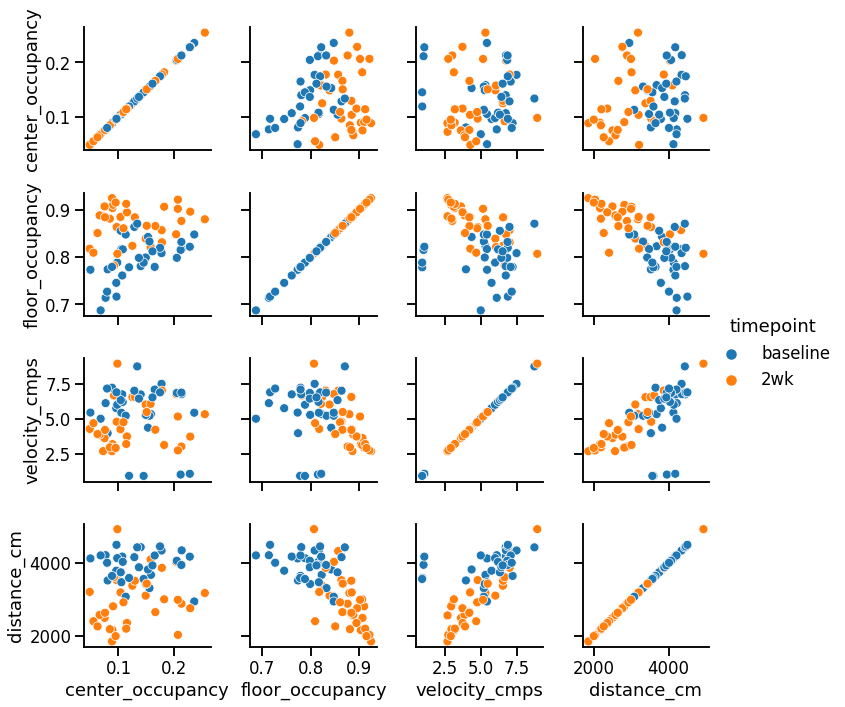

In [77]:
df_in = df_joined[df_joined['timepoint']!= '4wk']
g = sns.PairGrid(df_in, hue='timepoint')
g.map(sns.scatterplot)
g.add_legend()

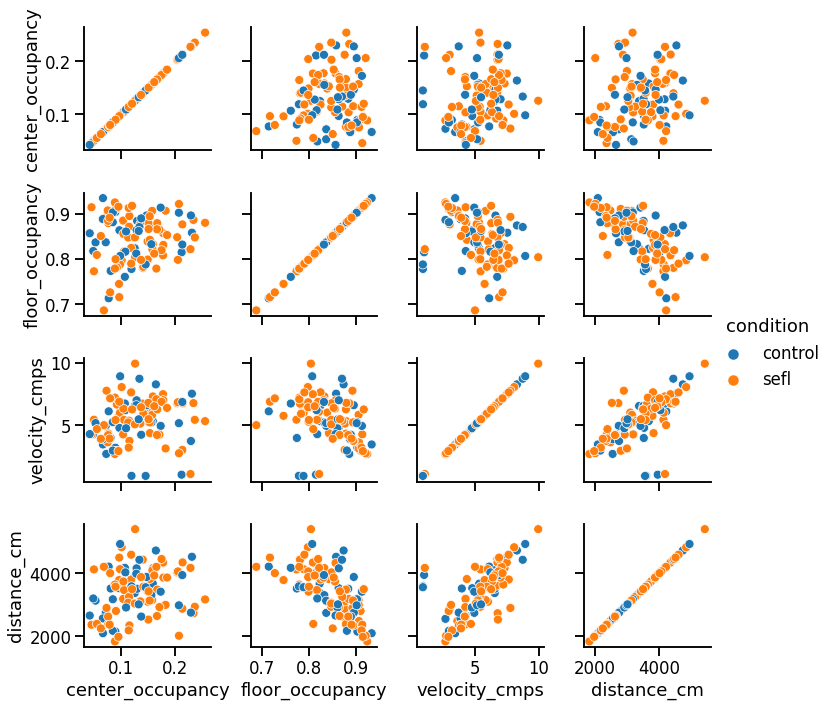

In [53]:
g = sns.PairGrid(df_joined, hue='condition')
g.map(sns.scatterplot)
g.add_legend()

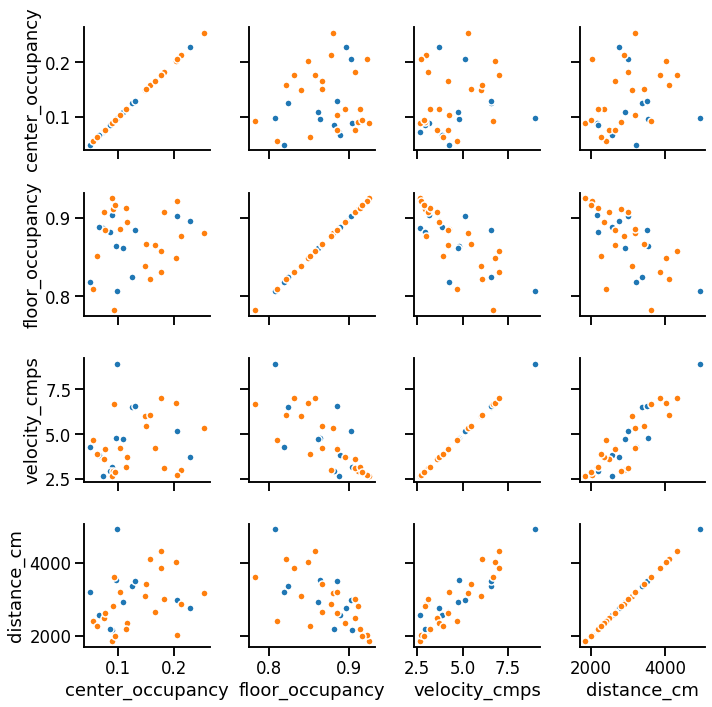

In [72]:
g = sns.PairGrid(df_joined[df_joined['timepoint']=='2wk'], hue='condition')
g.map(plt.scatter, s=50, edgecolor="white")
# g.map(sns.regplot, color=".3")
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])

In [91]:
df_joined

,sex,condition,behavior,timepoint,center_occupancy,floor_occupancy,velocity_cmps,distance_cm,els
cohort_id,,,,,,,,,
ptsd2_81,male,control,OFT,baseline,0.158255,0.822902,5.330484,3676.576855,n
ptsd2_81,male,control,OFT,2wk,0.124919,0.823925,6.546537,3377.576542,n
ptsd2_81,male,control,OFT,4wk,0.230417,0.858311,7.539227,4530.445303,n
ptsd2_82,male,control,OFT,baseline,0.080647,0.773962,3.966946,3522.152486,n
ptsd2_82,male,control,OFT,2wk,0.096786,0.863687,4.785019,3531.775275,n
...,...,...,...,...,...,...,...,...,...
ptsd6_74,female,sefl,OFT,baseline,0.160928,0.812165,6.527605,3936.644077,n
ptsd6_74,female,sefl,OFT,4wk,0.184584,0.853131,6.396093,3871.233827,n
ptsd6_75,female,sefl,OFT,2wk,0.062533,0.850985,3.903877,2256.438408,n


In [116]:
df_trans = df_joined.reset_index().pivot(index=['cohort_id', 'sex', 'behavior',
                                              'els', 'condition'],
                                         columns='timepoint',
                                         values=['center_occupancy','floor_occupancy',
                                                 'velocity_cmps','distance_cm'])
df_trans['n_floor_occ_2wk'] = df_trans[('floor_occupancy', 'baseline')] / df_trans[('floor_occupancy', '2wk')]
df_trans['n_floor_occ_4wk'] = df_trans[('floor_occupancy', 'baseline')] / df_trans[('floor_occupancy', '4wk')]

In [135]:
def normalizator(df, var):
  d = df[(var, 'baseline')] / df[(var, '2wk')]
  d1 = {'timepoint': '2w', var: d}
  center_occ_2wk = pd.DataFrame(data=d1)
  d3 = df[(var, 'baseline')] / df[(var, '4wk')]
  d4 = d1 = {'timepoint': '4w', var: d3}
  center_occ_4wk = pd.DataFrame(data=d1)
  center_occ = pd.concat([center_occ_2wk, center_occ_4wk])
  center_occ.reset_index(inplace=True)
  return center_occ

In [129]:
d = df_trans[('floor_occupancy', 'baseline')] / df_trans[('floor_occupancy', '2wk')]
d1 = {'timepoint': '2w', 'occ': d}
center_occ_2wk = pd.DataFrame(data=d1)
d3 = df_trans[('floor_occupancy', 'baseline')] / df_trans[('floor_occupancy', '4wk')]
d4 = d1 = {'timepoint': '4w', 'occ': d3}
center_occ_4wk = pd.DataFrame(data=d1)
center_occ = pd.concat([center_occ_2wk, center_occ_4wk])
center_occ.reset_index(inplace=True)
center_occ

,cohort_id,sex,behavior,els,condition,timepoint,occ
0,ptsd2_81,male,OFT,n,control,2w,0.998758
1,ptsd2_82,male,OFT,n,control,2w,0.896114
2,ptsd2_83,male,OFT,n,sefl,2w,0.921306
3,ptsd2_84,male,OFT,n,sefl,2w,1.025994
4,ptsd2_85,male,OFT,n,sefl,2w,0.846757
...,...,...,...,...,...,...,...
63,ptsd6_71,female,OFT,n,control,4w,0.965236
64,ptsd6_72,female,OFT,n,sefl,4w,0.895372
65,ptsd6_73,female,OFT,n,sefl,4w,0.895521
66,ptsd6_74,female,OFT,n,sefl,4w,0.951981


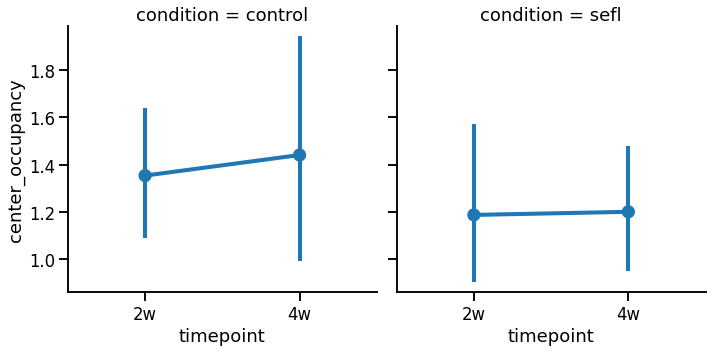

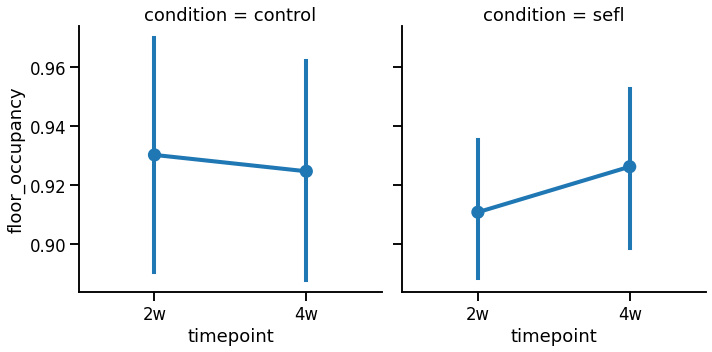

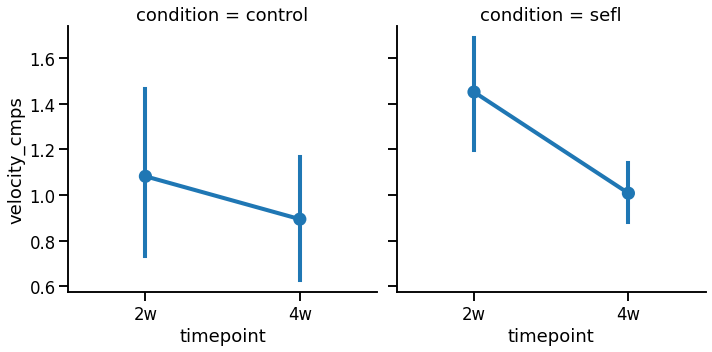

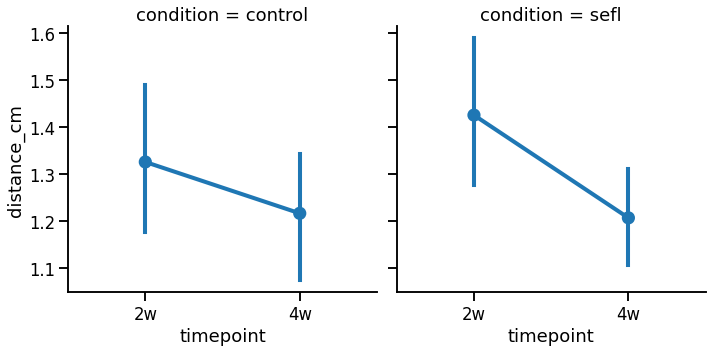

In [152]:
vars = ['center_occupancy','floor_occupancy', 'velocity_cmps','distance_cm' ]

for var in vars:
  sns.catplot(data=normalizator(df_trans, var), x='timepoint', y=var, 
            col='condition', kind='point')  

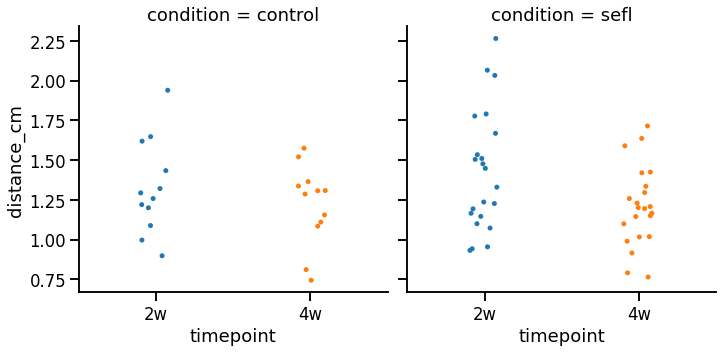

In [142]:
g = sns.catplot(data=normalizator(df_trans, var), x='timepoint', y=var, 
            col='condition')

In [150]:
g.axes_dict['control']